### Mount Google Drive with Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Import the required Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

C:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Import | View | Pre-Processing DATASET

In [5]:
# Data Augmentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [7]:
# Dataset Training
train_dataset  = train_datagen.flow_from_directory(directory = r"C:\Users\ASUS\Downloads\Alzheimer_s Dataset\train",
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [9]:
# Data Validation
valid_dataset = valid_datagen.flow_from_directory(directory =  r"C:\Users\ASUS\Downloads\Alzheimer_s Dataset\train",
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:33<00:00,  6.73s/it]


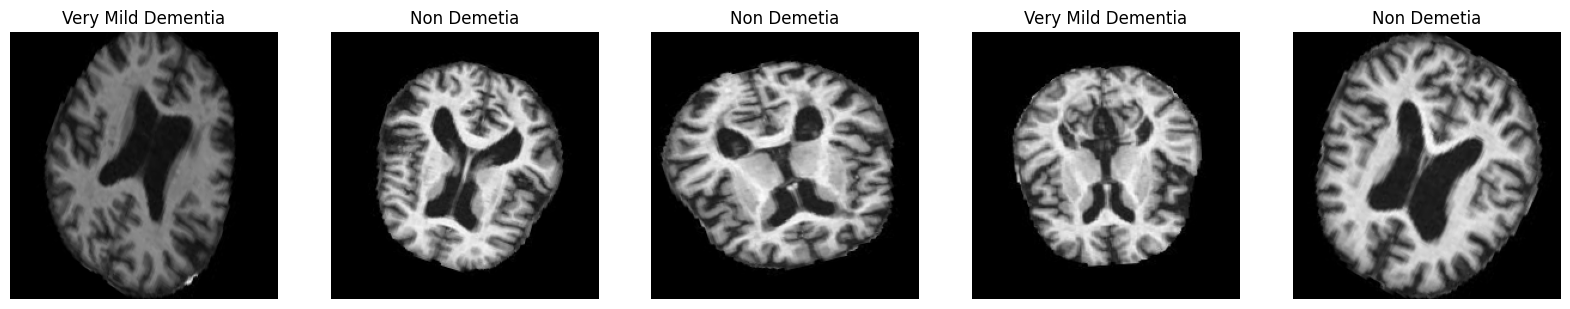

In [11]:
# Images views from different classes 
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### Build the Model

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def conv_block(x, growth_rate):
    """A building block for Dense blocks with batch norm, relu, and conv."""
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(growth_rate, (3, 3), padding='same')(x)
    return x

def dense_block(x, num_convs, growth_rate):
    """A Dense Block with multiple conv blocks."""
    for _ in range(num_convs):
        conv = conv_block(x, growth_rate)
        x = tf.keras.layers.Concatenate()([x, conv])
    return x

def transition_layer(x, reduction):
    """A transition layer to reduce the size of the feature map."""
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), (1, 1))(x)
    x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
    return x

def build_densenet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    # Example: Add Dense blocks and transition layers
    x = dense_block(x, num_convs=6, growth_rate=32)
    x = transition_layer(x, reduction=0.5)
    x = dense_block(x, num_convs=12, growth_rate=32)
    x = transition_layer(x, reduction=0.5)
    x = dense_block(x, num_convs=32, growth_rate=32)
    x = transition_layer(x, reduction=0.5)
    x = dense_block(x, num_convs=32, growth_rate=32)

    # Global Average Pooling and Output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
base_model = build_densenet(input_shape=(224, 224, 3), num_classes=4)
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_86 (Conv2D)          (None, 112, 112, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)           0         ['conv2d_86[0][0]']           
 g2D)                                                                                             
                                                                                                  
 batch_normalization_85 (Ba  (None, 56, 56, 64)           256       ['max_pooling2d_4[0][0]'

In [18]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [20]:
# Building Model and adjust the required parameters

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [22]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 4)                 19969988  
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 batch_normalization_170 (B  (None, 4)                 16        
 atchNormalization)                                              
                                                                 
 dense_2 (Dense)             (None, 2048)              10240     
                                                                 
 batch_normalization_171 (B  (None, 2048)              8192      
 atchNormalization)                                     

In [24]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [26]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
# Training the model using number of epochs
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 5,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/5
21/33 [==================>...........] - ETA: 2:46 - loss: 1.6042 - auc: 0.6915

### MODEL EVALUATION

In [ ]:
# Summarize history for loss function

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

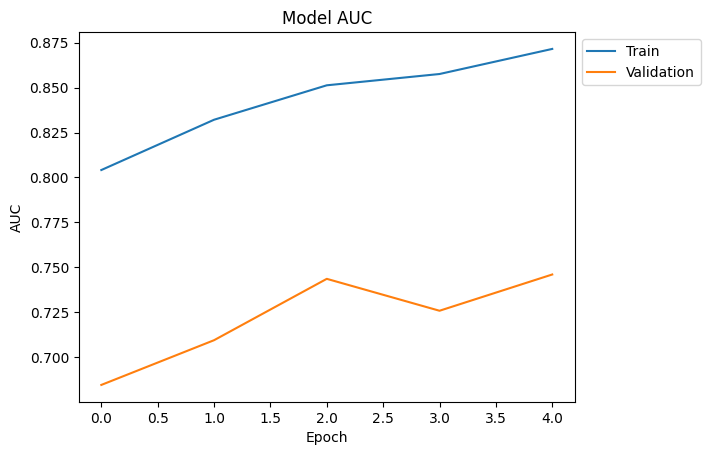

In [22]:
# Summarize history for loss and value accuracy

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [24]:
# Test Model using the Test Dataset

test_dataset  = test_datagen.flow_from_directory(directory = r"C:\Users\ASUS\Downloads\Alzheimer_s Dataset\test",
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [25]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 80s 8s/step - loss: 1.0442 - auc: 0.8511


[1.0441949367523193, 0.8511091470718384]

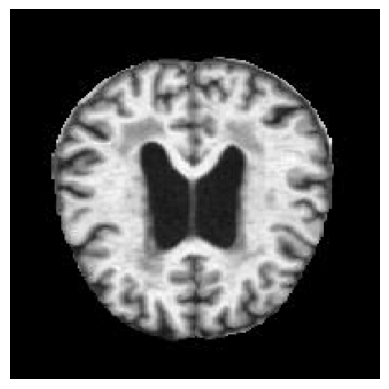

1/1 [==============================] - 5s 5s/step
84.22% chances are there that the image is NonDemented


In [34]:
# Test Case No.1: Non-Dementia
from keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
img_path = r"C:\Users\ASUS\Downloads\Alzheimer_s Dataset\test\NonDemented\32 (94).jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255  # Normalize to [0,1]

# Display the image
plt.imshow(img_array)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Prepare image for model prediction
img_expanded = np.expand_dims(img_array, axis=0)

# Predict the class with the model
predictions = model.predict(img_expanded)
predicted_class = np.argmax(predictions, axis=1)
probability = round(np.max(predictions) * 100, 2)

# Assuming 'idc' is a dictionary mapping class indices to class names
print(f"{probability}% chances are there that the image is {idc[predicted_class[0]]}")

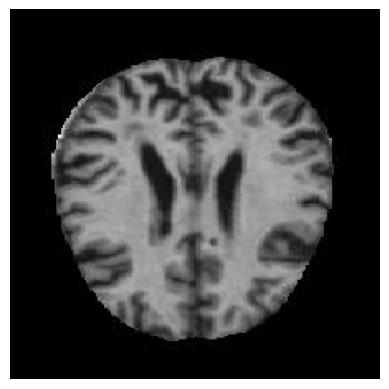

1/1 [==============================] - 0s 224ms/step
85.3% chances are there that the image is Class3


In [36]:
# Test Case 2: Mild Demented

from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is already loaded and available in your environment

# Image path
img_path = r"C:\Users\ASUS\Downloads\Alzheimer_s Dataset\test\MildDemented\32 (13).jpg"

# Load the image
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array /= 255  # Normalize the image array

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()

# Prepare image for model prediction
img_expanded = np.expand_dims(img_array, axis=0)

# Make a prediction
predictions = model.predict(img_expanded)
predicted_class_index = np.argmax(predictions, axis=1)
probability = round(np.max(predictions) * 100, 2)

# Map predicted class index to class name
class_names = {0: 'Class1', 1: 'Class2', 2: 'Class3', 3: 'Class4'}  # Update with your actual class names
predicted_class_name = class_names[predicted_class_index[0]]

print(f"{probability}% chances are there that the image is {predicted_class_name}")

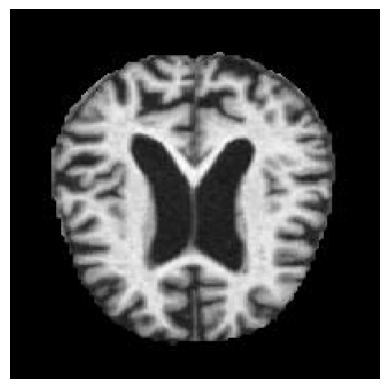

1/1 [==============================] - 0s 230ms/step
46.17% chance there is that the image is ModerateDemented


In [37]:
# Test Case 3: Moderate Demented

from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' and 'test_dataset' are already loaded and available in your environment

# Get class indices dictionary and invert it for looking up class names
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Load the image
img_path = r"C:\Users\ASUS\Downloads\Alzheimer_s Dataset\test\ModerateDemented\27 (2).jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array /= 255  # Normalize the image array

# Display the image
plt.imshow(img_array)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Prepare image for model prediction
img_expanded = np.expand_dims(img_array, axis=0)

# Make a prediction
predictions = model.predict(img_expanded)
predicted_class_index = np.argmax(predictions, axis=1)
probability = round(np.max(predictions) * 100, 2)

# Map predicted class index to class name
predicted_class_name = idc[predicted_class_index[0]]

print(f"{probability}% chance there is that the image is {predicted_class_name}")

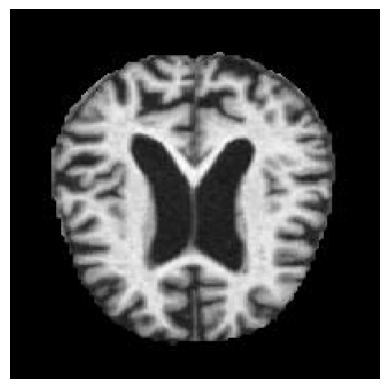

1/1 [==============================] - 0s 216ms/step
46.17% chance there is that the image is ModerateDemented


In [40]:
# Test Case 4: Very Mild Demented

from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' and 'test_dataset' are already loaded and available in your environment

# Get class indices dictionary and invert it for looking up class names
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Load the image
img_path = r"C:\Users\ASUS\Downloads\Alzheimer_s Dataset\test\VeryMildDemented\32 (68).jpg"

# Display the image
plt.imshow(img_array)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Prepare image for model prediction
img_expanded = np.expand_dims(img_array, axis=0)

# Make a prediction
predictions = model.predict(img_expanded)
predicted_class_index = np.argmax(predictions, axis=1)
probability = round(np.max(predictions) * 100, 2)

# Map predicted class index to class name
predicted_class_name = idc[predicted_class_index[0]]

# Ensure the print statement is correctly terminated
print(f"{probability}% chance there is that the image is {predicted_class_name}")

### Conclusion:

Finally built deep learning model using DenseNet162 transfer learning algorithm and acheived and AUC-90%.